In [6]:
# Importing Dependencies
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Mounting Google Drive.  Don't have to run again if it has already been mounted.
#drive.mount('/content/drive')

# Providing the Paths to the Training, Validation, and Testing data
training_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/1_Training'
validation_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/2_Validation'
testing_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/3_Testing'

# Resizing the jpgs to 128x128 to reduce processing needs and to provide uniform images
def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

# Loading the JPGs as B&W to save memory
def rgb_to_gray(image):
    return rgb2gray(image)

# Setting random seeds for Numpy & TensorFlow for reproducibility
np.random.seed(14)
tf.random.set_seed(14)

# All jpgs should be the same size (128,128), however, rescaling in anticipation of Neural Networking modeling later in the process.
# Allowing for some variation in image orientation.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Fitting the ImageDataGenerator onto the Training data
datagen.fit(np.zeros((1, 128, 128, 3)))

# Defining Training and Validation sets
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=924,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=230,
    class_mode='binary',
    subset='validation'
)

Found 463 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


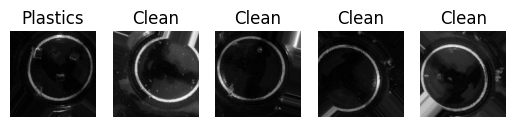

In [8]:
# Check to see what it is we loaded into the Training Set
# Loading the first batch from train_generator
batch = next(train_generator)

# Extracting the images and labels from the batch
images, labels = batch

# Updating labels for better readability
updated_labels = ["Clean" if label == 0 else "Plastics" for label in labels]

# Displaying the first few images along with their labels
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i][:, :, 0], cmap='gray')
    plt.title(f"{updated_labels[i]}")
    plt.axis('off')

plt.show()

In [9]:
# Double checking the shape of the output from the resizing
# Even though images are Greyscale, we want to make sure that the color channels are 3, so they are compatable with MobileNetV2.
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]
print("Shape after resize_images:", sample_image.shape)

Shape after resize_images: (128, 128, 3)


In [10]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the convolutional base
base_model.trainable = False

# Modeling with classification head on top of MobileNetV2
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Training the Model
epochs = 50

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model.evaluate(train_generator)
valid_loss, valid_accuracy = model.evaluate(validation_generator)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

Epoch 1/50
1/1 [==============================] - 16s 16s/step - loss: 0.4740 - accuracy: 0.7819 - val_loss: 0.4059 - val_accuracy: 0.8500
Epoch 2/50
1/1 [==============================] - 15s 15s/step - loss: 0.4937 - accuracy: 0.7754 - val_loss: 0.3429 - val_accuracy: 0.9000
Epoch 3/50
1/1 [==============================] - 16s 16s/step - loss: 0.4890 - accuracy: 0.7711 - val_loss: 0.3440 - val_accuracy: 0.8500
Epoch 4/50
1/1 [==============================] - 15s 15s/step - loss: 0.4998 - accuracy: 0.7667 - val_loss: 0.3168 - val_accuracy: 0.8500
Epoch 5/50
1/1 [==============================] - 15s 15s/step - loss: 0.4420 - accuracy: 0.7883 - val_loss: 0.3344 - val_accuracy: 0.9500
Epoch 6/50
1/1 [==============================] - 16s 16s/step - loss: 0.4336 - accuracy: 0.8099 - val_loss: 0.3267 - val_accuracy: 0.9000
Epoch 7/50
1/1 [==============================] - 15s 15s/step - loss: 0.4318 - accuracy: 0.8056 - val_loss: 0.3389 - val_accuracy: 0.8500
Epoch 8/50
1/1 [===========

In [18]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=False
)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model.evaluate(testing_generator)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')



Found 100 images belonging to 2 classes.
1/1 [==============================] - 4s 4s/step - loss: 0.2842 - accuracy: 0.9300
Testing Accuracy: 0.9300000071525574
Testing Loss: 0.28423434495925903


In [15]:
# Generating predictions on the testing set
predictions = model.predict(testing_generator)

# Converting predictions to binary values (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Getting true labels from the generator
true_labels = testing_generator.classes

# Displaying confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Displaying classification report
classification_rep = classification_report(true_labels, binary_predictions)
print("Classification Report:")
print(classification_rep)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

1/1 [==============================] - 4s 4s/step
Confusion Matrix:
[[81  0]
 [14  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        81
           1       1.00      0.26      0.42        19

    accuracy                           0.86       100
   macro avg       0.93      0.63      0.67       100
weighted avg       0.88      0.86      0.82       100

Testing Accuracy: 0.949999988079071
Testing Loss: 0.25900378823280334


In [80]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the testing path and plastic subdirectory
testing_path2 = '/content/drive/MyDrive/P4_MicroPystics/Resources/3_Testing/2_Macroplastics'
#plastic = "2_Macroplastics"

val_path = os.path.join(testing_path2)
val_pics = os.listdir(testing_path2)

# Assuming val_pics is a list of image paths
image_filename = val_pics[11]

In [81]:
image_filename
image_path = os.path.join(testing_path2, image_filename)

In [84]:
# Load and preprocess the single image
img = image.load_img(image_path, target_size=(128, 128))  # Adjust the target_size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
#img_array = preprocess_input(img_array)  # Assuming you have a preprocess_input function

# Generate predictions for the single image
single_image_predictions = model.predict(img_array)

# Convert predictions to binary values (0 or 1)
single_image_binary_prediction = (single_image_predictions > 0.5).astype(int)

# Print the results
print("Raw Predictions:", single_image_predictions)
print("Binary Prediction:", single_image_binary_prediction)

1/1 [==============================] - 2s 2s/step
Raw Predictions: [[0.98382413]]
Binary Prediction: [[1]]


In [ ]:
# Saving as H5 file for Interactive Model
model.save_weights('MicroPystics.h5')

In [85]:
model.save("modelv2/saved_model", save_format="tf")

!zip -r /content/modelv2.zip /content/modelv2

  adding: content/modelv2/ (stored 0%)
  adding: content/modelv2/saved_model/ (stored 0%)
  adding: content/modelv2/saved_model/assets/ (stored 0%)
  adding: content/modelv2/saved_model/fingerprint.pb (stored 0%)
  adding: content/modelv2/saved_model/variables/ (stored 0%)
  adding: content/modelv2/saved_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/modelv2/saved_model/variables/variables.index (deflated 76%)
  adding: content/modelv2/saved_model/keras_metadata.pb (deflated 96%)
  adding: content/modelv2/saved_model/saved_model.pb (deflated 91%)


In [14]:
# # Testing alternative activation functions to find best candidates

# # Creating activation list
# activation_functions = ['leaky_relu', 'elu', 'tanh', 'selu', 'sigmoid', 'relu']

# # Creating a dictionary to hold the activation function accuracy results
# results = {}

# # For-Looping the activation functions through the model
# for activation in activation_functions:
#     print(f"Training model with activation: {activation}")

#     model = Sequential([
#         base_model,
#         GlobalAveragePooling2D(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(64, activation=activation),
#         Dropout(0.3),
#         Dense(1, activation='sigmoid')
#     ])

#     model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#     # Training the model
#     history = model.fit(train_generator, epochs=15, validation_data=validation_generator)

#     # Pulling the results
#     results[activation] = history.history['val_accuracy']

# # Plotting the results
# plt.figure(figsize=(10, 6))

Training model with activation: leaky_relu
Epoch 1/15
1/1 [==============================] - 21s 21s/step - loss: 1.5362 - accuracy: 0.2873 - val_loss: 0.5787 - val_accuracy: 0.8000
Epoch 2/15
1/1 [==============================] - 15s 15s/step - loss: 0.7608 - accuracy: 0.5680 - val_loss: 0.5319 - val_accuracy: 0.8000
Epoch 3/15
1/1 [==============================] - 15s 15s/step - loss: 0.6673 - accuracy: 0.7041 - val_loss: 0.5356 - val_accuracy: 0.8000
Epoch 4/15
1/1 [==============================] - 15s 15s/step - loss: 0.7079 - accuracy: 0.7279 - val_loss: 0.5152 - val_accuracy: 0.8000
Epoch 5/15
1/1 [==============================] - 16s 16s/step - loss: 0.7269 - accuracy: 0.7149 - val_loss: 0.4978 - val_accuracy: 0.8000
Epoch 6/15
1/1 [==============================] - 16s 16s/step - loss: 0.6831 - accuracy: 0.7192 - val_loss: 0.4997 - val_accuracy: 0.8000
Epoch 7/15
1/1 [==============================] - 15s 15s/step - loss: 0.6691 - accuracy: 0.7063 - val_loss: 0.4784 - val_a

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

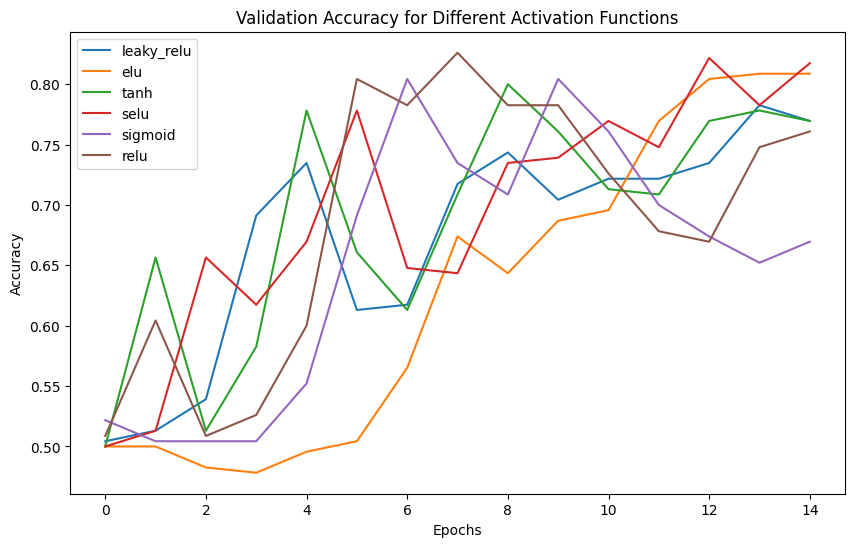

In [ ]:
# # Plot the results
# plt.figure(figsize=(10, 6))
# for activation, accuracy in results.items():
#     plt.plot(accuracy, label=activation)

# plt.title('Validation Accuracy for Different Activation Functions')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

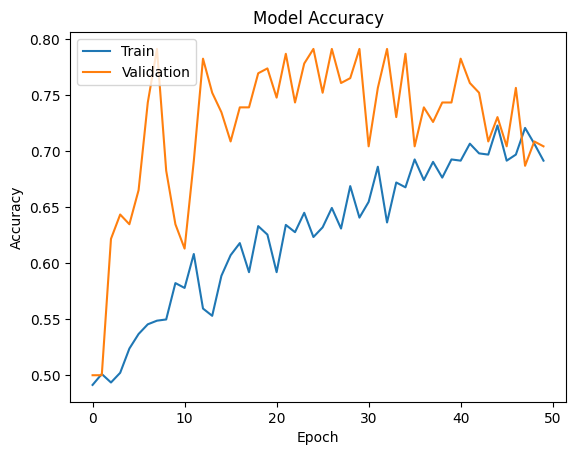

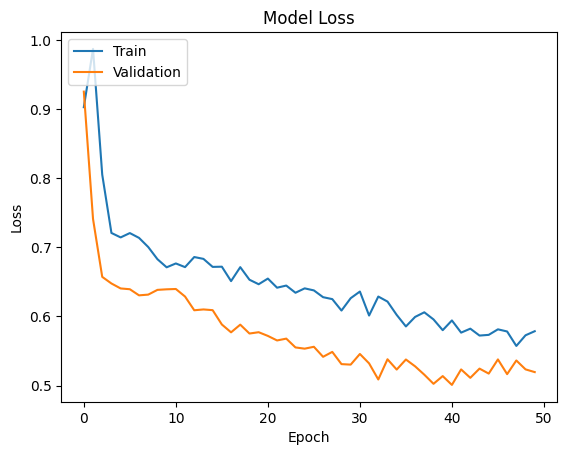

In [ ]:
# # Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()